In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd  # Import pandas for reading CSV

# Set a random seed for reproducibility
torch.manual_seed(0)

# Simulate time series data
seq_length = 16000  # Update sequence length
input_size = 6  # Update input size
output_size = 1

# Generate example data
# Replace this with loading your data from a CSV
df = pd.read_csv('Daily_RMSE.csv')
column_names = ['Doy', 'GPT2w_ZTD', 'Daily_RMSE']
Input = df[column_names]
Output = df['GAMIT_ZTD']
data = np.array(Input)
target = np.array(Output)

# Convert data to PyTorch tensors
data_tensor = torch.FloatTensor(data)
target_tensor = torch.FloatTensor(target)

# Move data and model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = data_tensor.to(device)
target_tensor = target_tensor.to(device)

# Define a Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, output_size):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model, nhead=2, num_encoder_layers=2)
        self.fc = nn.Linear(input_size, d_model)
        self.output = nn.Linear(d_model, output_size)

    def forward(self, src, tgt):
        src = self.fc(src)
        tgt = self.fc(tgt)
        out = self.transformer(src, tgt)
        out = self.output(out)
        return out

# Initialize the model and move it to the GPU
d_model = 64  # Transformer's dimension
model = TransformerModel(input_size, d_model, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
mae_values = []
mse_values = []
bias_values = []
loss_values = []

# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    mae_sum = 0.0
    mse_sum = 0.0
    bias_sum = 0.0

    start_time = time.time()  # Record start time for training

    for i in range(seq_length):
        inputs = data_tensor[i:i+1]
        targets = target_tensor[i:i+1]

        optimizer.zero_grad()
        outputs = model(inputs, inputs)  # Use the same input for both src and tgt
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Calculate MAE and MSE
        mae = torch.abs(outputs - targets).mean().item()
        mse = ((outputs - targets) ** 2).mean().item()

        mae_sum += mae
        mse_sum += mse

        # Calculate bias
        bias = (outputs - targets).mean().item()
        bias_sum += bias

        # Store MAE and MSE at each time step
        mae_values.append(mae)
        mse_values.append(mse)

    end_time = time.time()  # Record end time for training
    training_time = end_time - start_time
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Time: {training_time:.2f} seconds')

    # Calculate average MAE and MSE
    average_mae = mae_sum / seq_length
    average_mse = mse_sum / seq_length
    average_bias = bias_sum / seq_length

    loss_values.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average MAE: {average_mae:.4f}, Average MSE: {average_mse:.4f}, Average Bias: {average_bias:.4f}')

# Use the model for prediction and calculate MAE, MSE, and bias
predicted_outputs = []
predicted_mae_sum = 0.0
predicted_mse_sum = 0.0
predicted_bias_sum = 0.0
predicted_mae_concate = []
predicted_mse_concate = []

start_time = time.time()  # Record start time for inference

with torch.no_grad():
    for i in range(seq_length):
        test_input = data_tensor[i:i+1]
        predicted_output = model(test_input, test_input)

        # Calculate MAE, MSE, and bias for the predicted outputs
        predicted_mae = torch.abs(predicted_output - target_tensor[i:i+1]).mean().item()
        predicted_mse = ((predicted_output - target_tensor[i:i+1]) ** 2).mean().item()

        predicted_mae_sum += predicted_mae
        predicted_mse_sum += predicted_mse
        predicted_mae_concate.append(predicted_mae)
        predicted_mse_concate.append(predicted_mse)
        predicted_bias = (predicted_output - target_tensor[i:i+1]).mean().item()
        predicted_bias_sum += predicted_bias

end_time = time.time()  # Record end time for inference
inference_time = end_time - start_time

# Calculate


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table

np.random.seed(42)
pd.set_option('display.max_columns', 7)
std = 0.3
means = [0.2, 0.3, 0.5, 0.8, 0.85, 0.9]
sample_size = 50
data = pd.DataFrame()
for i, mean in enumerate(means):
    data['pop_%i' % i] = np.random.normal(mean, std, sample_size).clip(0, 1)

In [30]:
import pandas as pd
data=pd.read_csv("Multi and uni on MSE.csv")

In [31]:
data

,Periormer,FEDformer,Autoformer,Informer,LogTrans,Reformer
0,0.118,0.138,0.095,0.098,0.103,0.222
1,0.136,0.156,0.144,0.158,0.167,0.284
2,0.157,0.197,0.182,0.179,0.207,1.522
3,0.172,0.205,0.186,0.191,0.230,1.860
4,0.192,0.233,0.205,0.222,0.273,2.122
...,...,...,...,...,...,...
75,0.295,0.399,0.421,0.468,0.527,0.563
76,0.344,0.415,0.437,0.528,0.610,0.694
77,0.357,0.476,0.483,0.637,0.679,0.740
78,0.428,0.537,0.614,0.679,0.806,0.893


In [32]:
result=autorank(data, alpha=0.05, verbose=False)
print(result)

RankResult(rankdf=
            meanrank  median     mad ci_lower ci_upper effect_size   magnitude
Periormer    5.88750  0.3505  0.1935    0.192    0.617         0.0  negligible
FEDformer    4.33750  0.4370   0.241    0.222    0.714   -0.266964       small
Autoformer   4.00000  0.4530  0.2625    0.248    0.732   -0.299812       small
Informer     3.32500  0.5175  0.2855    0.313    0.857   -0.461871       small
LogTrans     2.25625  0.6235   0.313    0.334    0.877   -0.707663      medium
Reformer     1.19375  0.8585   0.458    0.506    1.269   -0.974597       large
pvalue=7.092463789123216e-65
cd=0.8429434015371722
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[1.1941232891388154e-08, 3.168653339713501e-09, 7.060440676553981e-09, 3.125241576640292e-08, 1.560624340868344e-08, 0.00011791979341069236]
homoscedastic=True
pval_homogeneity=0.07397543383869123
homogeneity_test=levene
alpha=0.05
alpha_normality=0.008333333333333333
num_samples=80
posterior_matrix=
None
decisi

In [33]:
create_report(result)

The statistical analysis was conducted for 6 populations with 80 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations Periormer (p=0.000), FEDformer (p=0.000), Autoformer (p=0.000), Informer (p=0.000), LogTrans (p=0.000), and Reformer (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=0.843 of

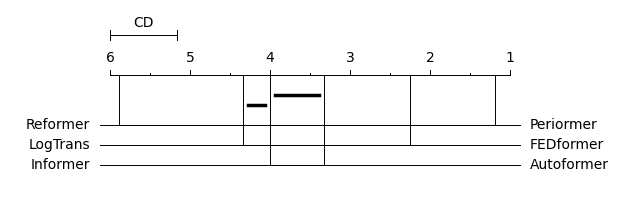

In [34]:
plot_stats(result)
plt.show()

In [29]:
latex_table(result)

\begin{table}[h]
\centering
\begin{tabular}{lrrllll}
\toprule
{} &    MR &   MED &   MAD &              CI & $\gamma$ &   Magnitude \\
\midrule
Periormer  & 5.888 & 0.350 & 0.193 &  [0.192, 0.617] &     0.000 &  negligible \\
Fedformer  & 4.338 & 0.437 & 0.241 &  [0.222, 0.714] &    -0.267 &       small \\
Autoformer & 4.000 & 0.453 & 0.262 &  [0.248, 0.732] &    -0.300 &       small \\
Informer   & 3.325 & 0.518 & 0.286 &  [0.313, 0.857] &    -0.462 &       small \\
LogTrans   & 2.256 & 0.623 & 0.313 &  [0.334, 0.877] &    -0.708 &      medium \\
Reformer   & 1.194 & 0.859 & 0.458 &  [0.506, 1.269] &    -0.975 &       large \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}


C:\Users\77154\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\autorank\autorank.py:697: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_string = table_df.to_latex(float_format=float_format, na_rep='-').strip()
